# Verification: Corrected E Matrix and Prevalence

This notebook verifies that the saved files in `data_for_running/` match the corrected versions computed from the workflow:

1. **E_matrix_corrected.pt**: Verifies it matches recomputation from E_matrix.pt + censor_info.csv
2. **prevalence_t_corrected.pt**: Verifies it matches recomputation from Y_tensor.pt + E_matrix_corrected.pt

This confirms the workflow was executed correctly.


In [1]:
# ============================================================================
# Setup
# ============================================================================

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.ndimage import gaussian_filter1d

data_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')

print("Setup complete")


Setup complete


## Step 1: Verify E_matrix_corrected.pt


STEP 1: VERIFYING E_MATRIX_CORRECTED.PT

✓ Loaded saved E_matrix_corrected: torch.Size([407878, 348])
✓ Loaded original E_matrix: torch.Size([407878, 348])
✓ Loaded censor_info.csv: 407878 patients

✓ Recomputed E_matrix_corrected: torch.Size([407878, 348])

COMPARISON

✅ PERFECT MATCH! E_matrix_corrected.pt matches recomputation


## Step 2: Verify prevalence_t_corrected.pt


In [3]:
# ============================================================================
# Step 2: Load saved prevalence_t_corrected and recompute from scratch
# ============================================================================

print("\n" + "="*80)
print("STEP 2: VERIFYING PREVALENCE_T_CORRECTED.PT")
print("="*80)

# Load saved corrected prevalence
prevalence_t_saved = torch.load(str(data_dir / 'prevalence_t_corrected.pt'), weights_only=False)
if torch.is_tensor(prevalence_t_saved):
    prevalence_t_saved = prevalence_t_saved.numpy()
print(f"\n✓ Loaded saved prevalence_t_corrected: {prevalence_t_saved.shape}")

# Load Y and E_corrected to recompute
Y = torch.load(str(data_dir / 'Y_tensor.pt'), weights_only=False)
E_corrected = torch.load(str(data_dir / 'E_matrix_corrected.pt'), weights_only=False)
censor_df = pd.read_csv(str(data_dir / 'censor_info.csv'))
enrollment_ages = censor_df['age'].values

print(f"✓ Loaded Y_tensor: {Y.shape}")
print(f"✓ Loaded E_matrix_corrected: {E_corrected.shape}")
print(f"✓ Loaded enrollment ages: {len(enrollment_ages)} patients")

# Recompute prevalence using the same function
def compute_smoothed_prevalence_at_risk(Y, E_corrected, enrollment_ages, window_size=5, smooth_on_logit=True):
    """
    Compute smoothed prevalence with proper at-risk filtering.
    
    Parameters:
    -----------
    Y : torch.Tensor (N × D × T)
    E_corrected : torch.Tensor (N × D) - corrected event/censor times
    enrollment_ages : np.ndarray (N,) - enrollment ages for each person
    window_size : int - Gaussian smoothing window size
    smooth_on_logit : bool - Smooth on logit scale
    """
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(E_corrected):
        E_corrected = E_corrected.numpy()
    
    N, D, T = Y.shape
    prevalence_t = np.zeros((D, T))
    
    # Convert timepoints to ages (assuming timepoint 0 = age 30)
    timepoint_ages = np.arange(T) + 30
    
    print(f"\n  Computing prevalence for {D} diseases, {T} timepoints...")
    
    # Convert E_corrected to numpy if needed
    if torch.is_tensor(E_corrected):
        E_corrected_np = E_corrected.numpy()
    else:
        E_corrected_np = E_corrected
    
    for d in range(D):
        if d % 50 == 0:
            print(f"    Processing disease {d}/{D}...")
        
        for t in range(T):
            age_t = timepoint_ages[t]
            
            # Only include people who are still at risk at timepoint t
            at_risk_mask = (E_corrected_np[:, d] >= t) 
            
            if at_risk_mask.sum() > 0:
                if torch.is_tensor(Y):
                    prevalence_t[d, t] = Y[at_risk_mask, d, t].numpy().mean()
                else:
                    prevalence_t[d, t] = Y[at_risk_mask, d, t].mean()
            else:
                prevalence_t[d, t] = np.nan
        
        # Smooth as before
        if smooth_on_logit:
            epsilon = 1e-8
            # Handle NaN values
            valid_mask = ~np.isnan(prevalence_t[d, :])
            if valid_mask.sum() > 0:
                logit_prev = np.full(T, np.nan)
                logit_prev[valid_mask] = np.log(
                    (prevalence_t[d, valid_mask] + epsilon) / 
                    (1 - prevalence_t[d, valid_mask] + epsilon)
                )
                # Smooth only valid values
                smoothed_logit = gaussian_filter1d(
                    np.nan_to_num(logit_prev, nan=0), 
                    sigma=window_size
                )
                # Restore NaN where original was NaN
                smoothed_logit[~valid_mask] = np.nan
                prevalence_t[d, :] = 1 / (1 + np.exp(-smoothed_logit))
        else:
            prevalence_t[d, :] = gaussian_filter1d(
                np.nan_to_num(prevalence_t[d, :], nan=0), 
                sigma=window_size
            )
    
    return prevalence_t

# Recompute
print("\nRecomputing prevalence_t_corrected...")
prevalence_t_recomputed = compute_smoothed_prevalence_at_risk(
    Y=Y, 
    E_corrected=E_corrected, 
    enrollment_ages=enrollment_ages,
    window_size=5,
    smooth_on_logit=True
)

print(f"\n✓ Recomputed prevalence_t_corrected: {prevalence_t_recomputed.shape}")



STEP 2: VERIFYING PREVALENCE_T_CORRECTED.PT

✓ Loaded saved prevalence_t_corrected: (348, 52)
✓ Loaded Y_tensor: torch.Size([407878, 348, 52])
✓ Loaded E_matrix_corrected: torch.Size([407878, 348])
✓ Loaded enrollment ages: 407878 patients

Recomputing prevalence_t_corrected...

  Computing prevalence for 348 diseases, 52 timepoints...
    Processing disease 0/348...
    Processing disease 50/348...
    Processing disease 100/348...
    Processing disease 150/348...
    Processing disease 200/348...
    Processing disease 250/348...
    Processing disease 300/348...

✓ Recomputed prevalence_t_corrected: (348, 52)


In [4]:
# Compare recomputed prevalence with saved version
print(f"\n{'='*80}")
print("COMPARISON")
print(f"{'='*80}")

# Handle NaN values in comparison
valid_mask = ~(np.isnan(prevalence_t_saved) | np.isnan(prevalence_t_recomputed))

if valid_mask.sum() == 0:
    print("\n⚠️  No valid values to compare (all NaN)")
else:
    # Compare only valid values
    diff = np.abs(prevalence_t_saved - prevalence_t_recomputed)
    max_diff = np.nanmax(diff)
    mean_diff = np.nanmean(diff[valid_mask])
    
    # Check if they're close (allowing for small numerical differences from smoothing)
    close_match = np.allclose(prevalence_t_saved, prevalence_t_recomputed, 
                             equal_nan=True, rtol=1e-5, atol=1e-6)
    
    print(f"\nComparison statistics:")
    print(f"   Valid elements: {valid_mask.sum()} / {prevalence_t_saved.size}")
    print(f"   Max absolute difference: {max_diff:.8f}")
    print(f"   Mean absolute difference: {mean_diff:.8f}")
    
    if close_match:
        print(f"\n✅ CLOSE MATCH! prevalence_t_corrected.pt matches recomputation")
        print(f"   (Small differences expected due to numerical precision in smoothing)")
    else:
        print(f"\n⚠️  SIGNIFICANT DIFFERENCES DETECTED!")
        print(f"   Max diff: {max_diff:.8f}, Mean diff: {mean_diff:.8f}")
        
        # Show some examples of differences
        large_diff_mask = diff > 0.01
        if large_diff_mask.sum() > 0:
            print(f"\n   Found {large_diff_mask.sum()} elements with difference > 0.01")
            large_diff_indices = np.where(large_diff_mask)
            print(f"   Example differences:")
            for i in range(min(5, len(large_diff_indices[0]))):
                d_idx = large_diff_indices[0][i]
                t_idx = large_diff_indices[1][i]
                print(f"     Disease {d_idx}, Timepoint {t_idx}: "
                      f"Saved={prevalence_t_saved[d_idx, t_idx]:.6f}, "
                      f"Recomputed={prevalence_t_recomputed[d_idx, t_idx]:.6f}, "
                      f"Diff={diff[d_idx, t_idx]:.6f}")



COMPARISON

Comparison statistics:
   Valid elements: 18096 / 18096
   Max absolute difference: 0.00000000
   Mean absolute difference: 0.00000000

✅ CLOSE MATCH! prevalence_t_corrected.pt matches recomputation
   (Small differences expected due to numerical precision in smoothing)


## Summary


In [5]:
# Summary
print(f"\n{'='*80}")
print("VERIFICATION SUMMARY")
print(f"{'='*80}")

print("\n✓ Step 1: E_matrix_corrected.pt verification complete")
print("✓ Step 2: prevalence_t_corrected.pt verification complete")

print("\n" + "="*80)
print("If both verifications passed, the saved files match the workflow!")
print("="*80)



VERIFICATION SUMMARY

✓ Step 1: E_matrix_corrected.pt verification complete
✓ Step 2: prevalence_t_corrected.pt verification complete

If both verifications passed, the saved files match the workflow!


In [7]:
def create_proper_calibration_plots(checkpoint_path, cov_df, Y, E_corrected, n_bins=10, use_log_scale=True, min_bin_count=1000, save_path=None):
    """Create calibration plots comparing predicted vs observed event rates for at-risk individuals.
    
    Args:
        checkpoint_path: Path to model checkpoint
        cov_df: DataFrame containing enrollment ages
        Y: Tensor of observed events (N × D × T)
        E_corrected: Corrected E matrix (N × D) - event/censor times from corrected E matrix
        n_bins: Number of bins for calibration
        use_log_scale: Whether to use log-scale binning (recommended for rare events)
        min_bin_count: Minimum number of samples per bin
        save_path: Path to save plot
    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    state_dict = checkpoint['model_state_dict']
    
    # Get parameters from state dict
    lambda_ = state_dict['lambda_']  # Shape: (N, K, T)
    phi = state_dict['phi']  # Shape: (K, D, T)
    kappa = state_dict['kappa']  # Shape: scalar
    
    # Calculate theta (normalized lambda)
    theta = torch.softmax(lambda_, dim=1)
    
    # Calculate phi probabilities (sigmoid)
    phi_prob = torch.sigmoid(phi)
    
    # Calculate pi (disease probabilities)
    pi = torch.einsum('nkt,kdt->ndt', theta, phi_prob) * kappa
    
    # Convert to numpy
    pi_np = pi.detach().numpy()
    Y_np = Y.detach().numpy()
    
    # Convert E_corrected to numpy if needed
    if torch.is_tensor(E_corrected):
        E_corrected_np = E_corrected.detach().numpy()
    else:
        E_corrected_np = E_corrected
    
    N, D, T = Y_np.shape
    
    # Create at_risk mask using corrected E matrix
    # Patient i is at risk for disease d at timepoint t if E_corrected[i,d] >= t
    # This properly accounts for both events AND censoring
    at_risk = np.zeros((N, D, T), dtype=bool)
    for n in range(N):
        for d in range(D):
            # Patient is at risk at timepoint t if event/censor time >= t
            at_risk[n, d, :] = (E_corrected_np[n, d] >= np.arange(T))
    
    # Create two sets of predictions/observations
    
    # 1. Enrollment only
    enroll_pred = []
    enroll_obs = []
    
    for d in range(D):
        for i, row in enumerate(cov_df.itertuples()):
            enroll_age = row.age
            enroll_time = int(enroll_age - 30)  # Convert age to time index
            
            if enroll_time < 0 or enroll_time >= T:
                continue
                
            if at_risk[i,d,enroll_time]:
                enroll_pred.append(pi_np[i,d,enroll_time])
                enroll_obs.append(Y_np[i,d,enroll_time])
    
    # 2. All follow-up
    all_pred = []
    all_obs = []
    
    for t in range(T):
        mask_t = at_risk[:,:,t]
        if mask_t.sum() > 0:
            all_pred.extend(pi_np[:,:,t][mask_t])
            all_obs.extend(Y_np[:,:,t][mask_t])
    
    # Create figure with one subplot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    def plot_calibration(pred, obs, ax, title):
        # Create bins in log or linear space
        if use_log_scale:
            bin_edges = np.logspace(np.log10(max(1e-7, min(pred))), 
                                  np.log10(max(pred)), 
                                  n_bins + 1)
        else:
            bin_edges = np.linspace(min(pred), max(pred), n_bins + 1)
        
        # Calculate statistics for each bin
        bin_means = []
        obs_means = []
        counts = []
        
        for i in range(n_bins):
            mask = (pred >= bin_edges[i]) & (pred < bin_edges[i + 1])
            if np.sum(mask) >= min_bin_count:
                bin_means.append(np.mean(pred[mask]))
                obs_means.append(np.mean(obs[mask]))
                counts.append(np.sum(mask))
        
        # Plot
        if use_log_scale:
            ax.plot([1e-7, 1], [1e-7, 1], '--', color='gray', alpha=0.5, label='Perfect calibration')
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:
            ax.plot([0, max(pred)], [0, max(pred)], '--', color='gray', alpha=0.5, label='Perfect calibration')
        
        ax.plot(bin_means, obs_means, 'o-', color='#1f77b4', 
                markersize=8, linewidth=2, label='Observed rates')
        
        # Add counts as annotations
        for i, (x, y, c) in enumerate(zip(bin_means, obs_means, counts)):
            ax.annotate(f'n={c:,}', (x, y), xytext=(0, 10), 
                       textcoords='offset points', ha='center', fontsize=8)
        
        # Add summary statistics
        mse = np.mean((np.array(bin_means) - np.array(obs_means))**2)
        mean_pred = np.mean(pred)
        mean_obs = np.mean(obs)
        
        stats_text = f'MSE: {mse:.2e}\n'
        stats_text += f'Mean Predicted: {mean_pred:.2e}\n'
        stats_text += f'Mean Observed: {mean_obs:.2e}\n'
        stats_text += f'N total: {sum(counts):,}'
        
        ax.text(0.05, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.grid(True, which='both', linestyle='--', alpha=0.3)
        ax.set_xlabel('Predicted Event Rate', fontsize=12)
        ax.set_ylabel('Observed Event Rate', fontsize=12)
        ax.set_title(title, fontsize=14, pad=20)
        ax.legend(loc='lower right')
    
    # Create calibration plot
    plot_calibration(np.array(all_pred), np.array(all_obs), 
                    ax, 'Calibration Across All Follow-up\n(At-Risk Only)')
    
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    
    return fig

✓ Loaded Y: torch.Size([10000, 348, 52])
✓ Loaded E_corrected: torch.Size([10000, 348])
✓ Loaded cov_df: 10000 patients


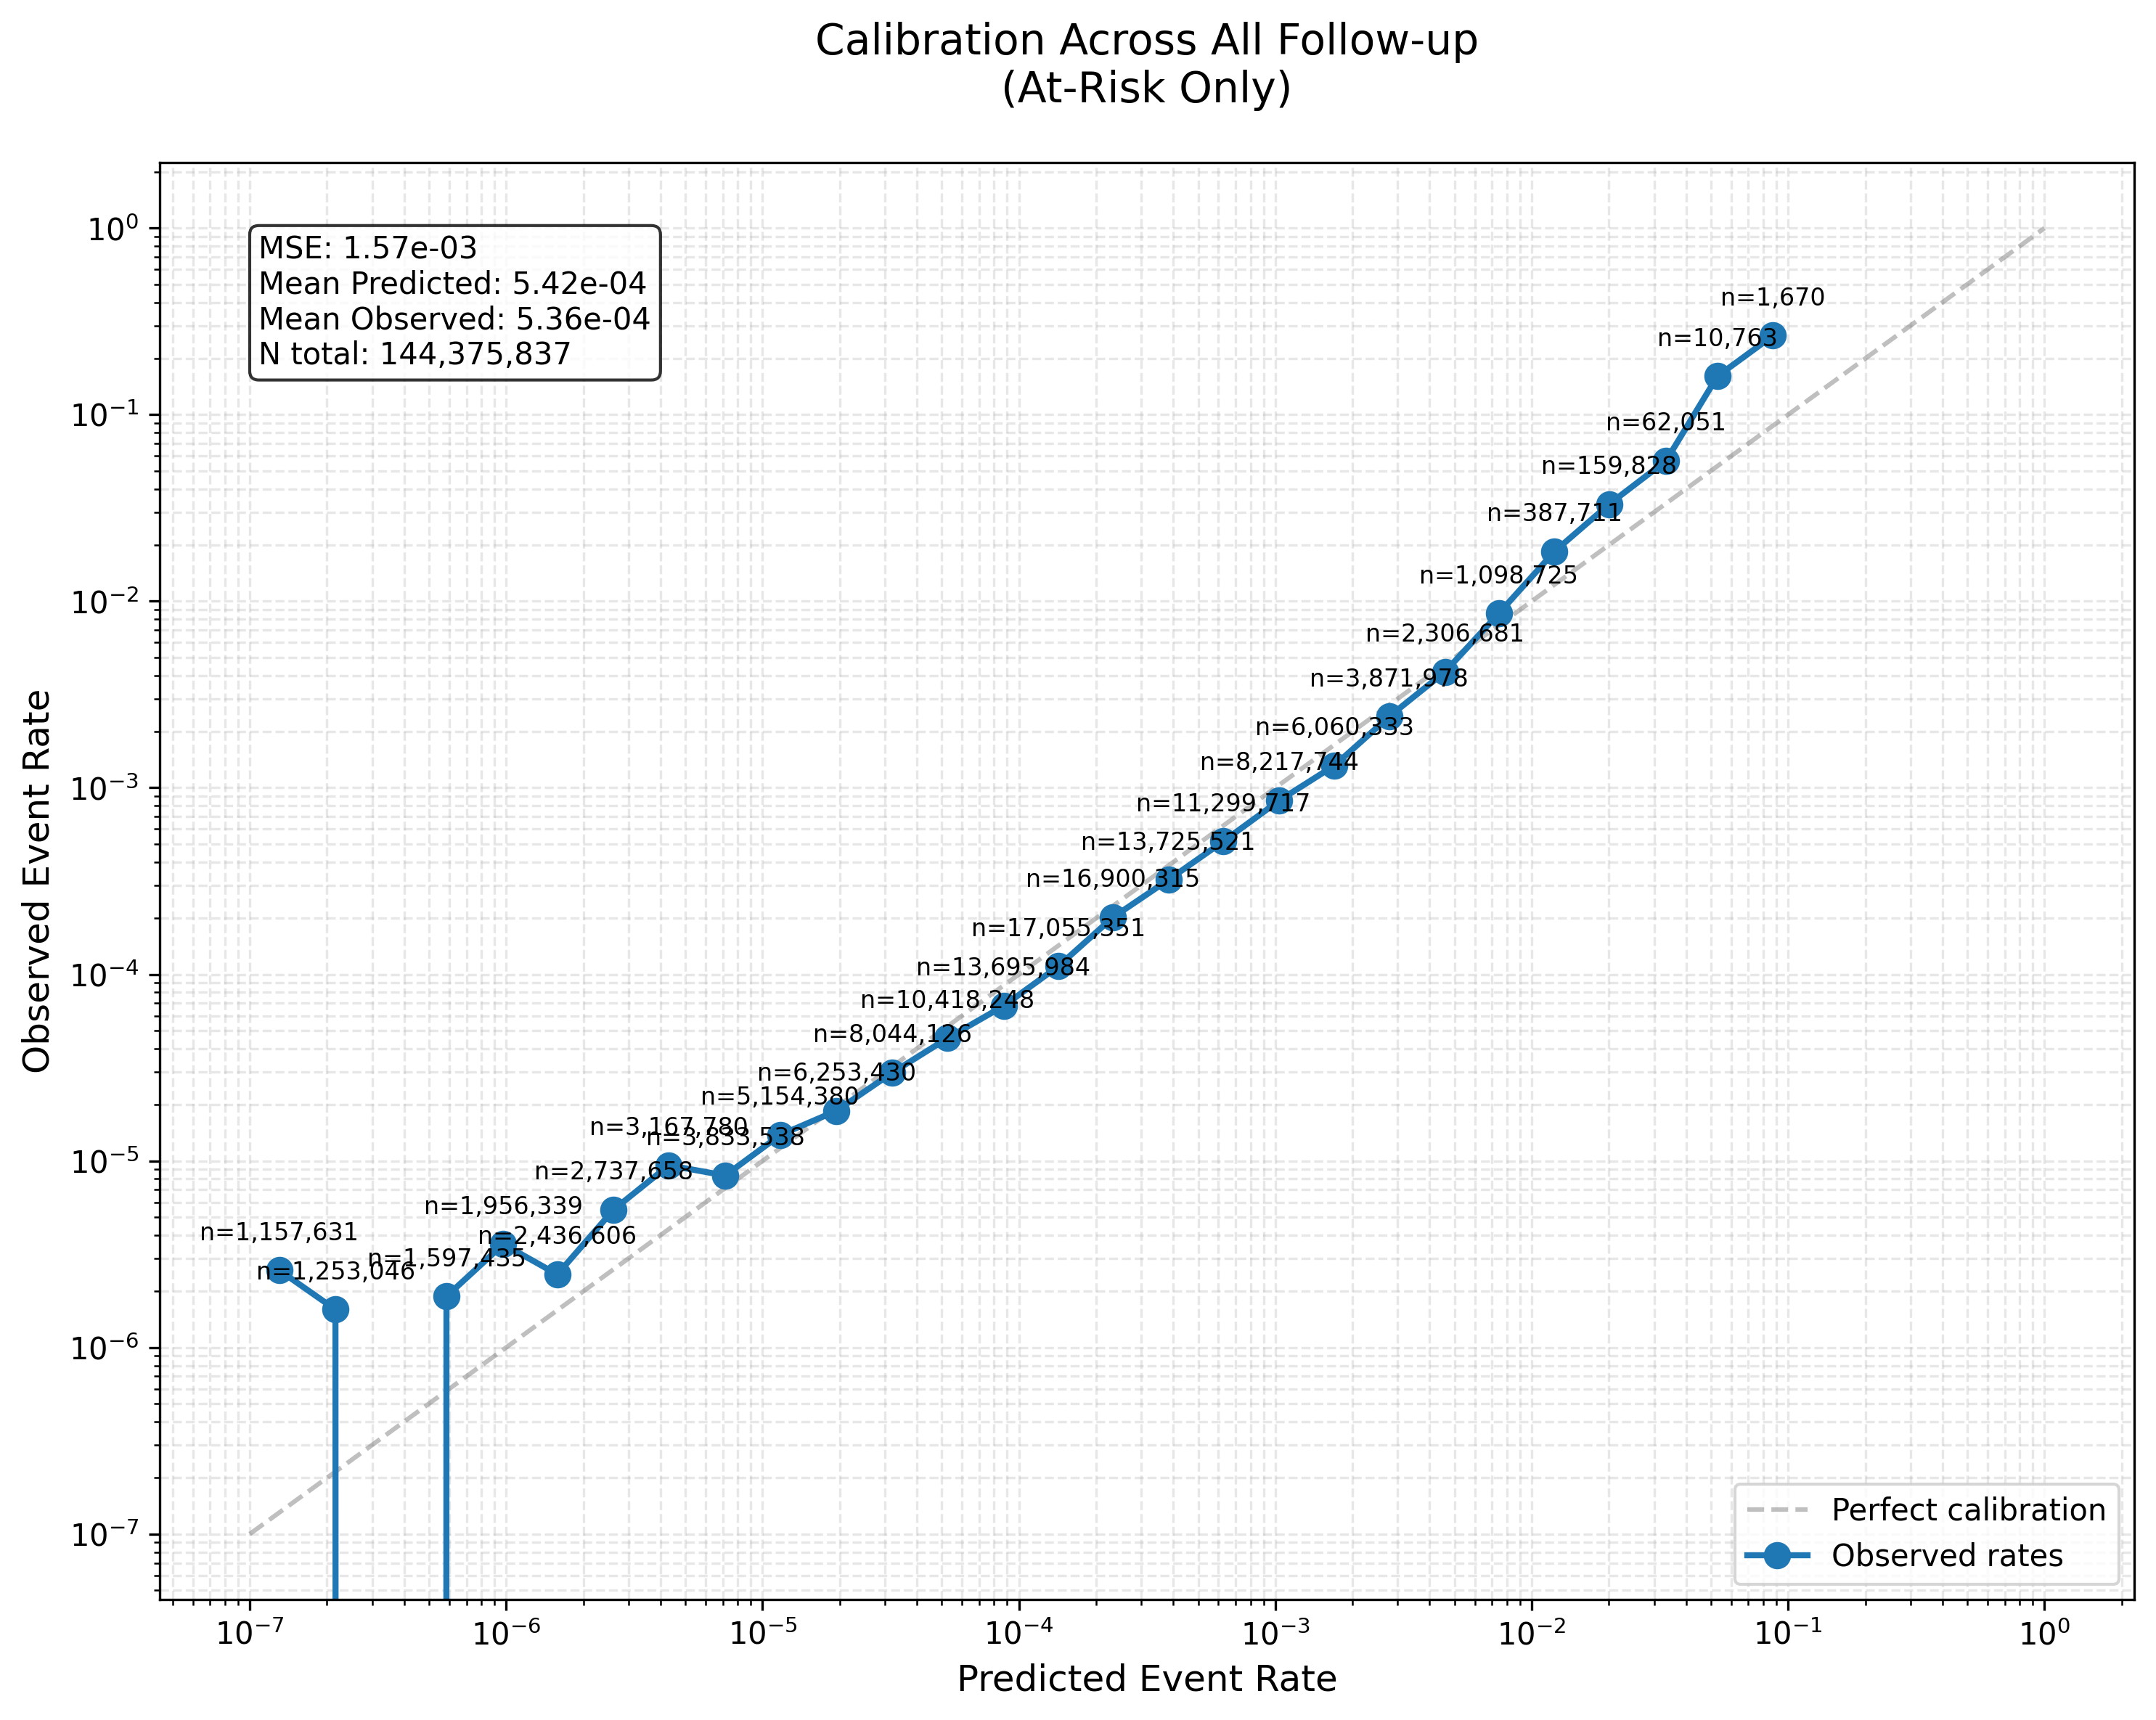

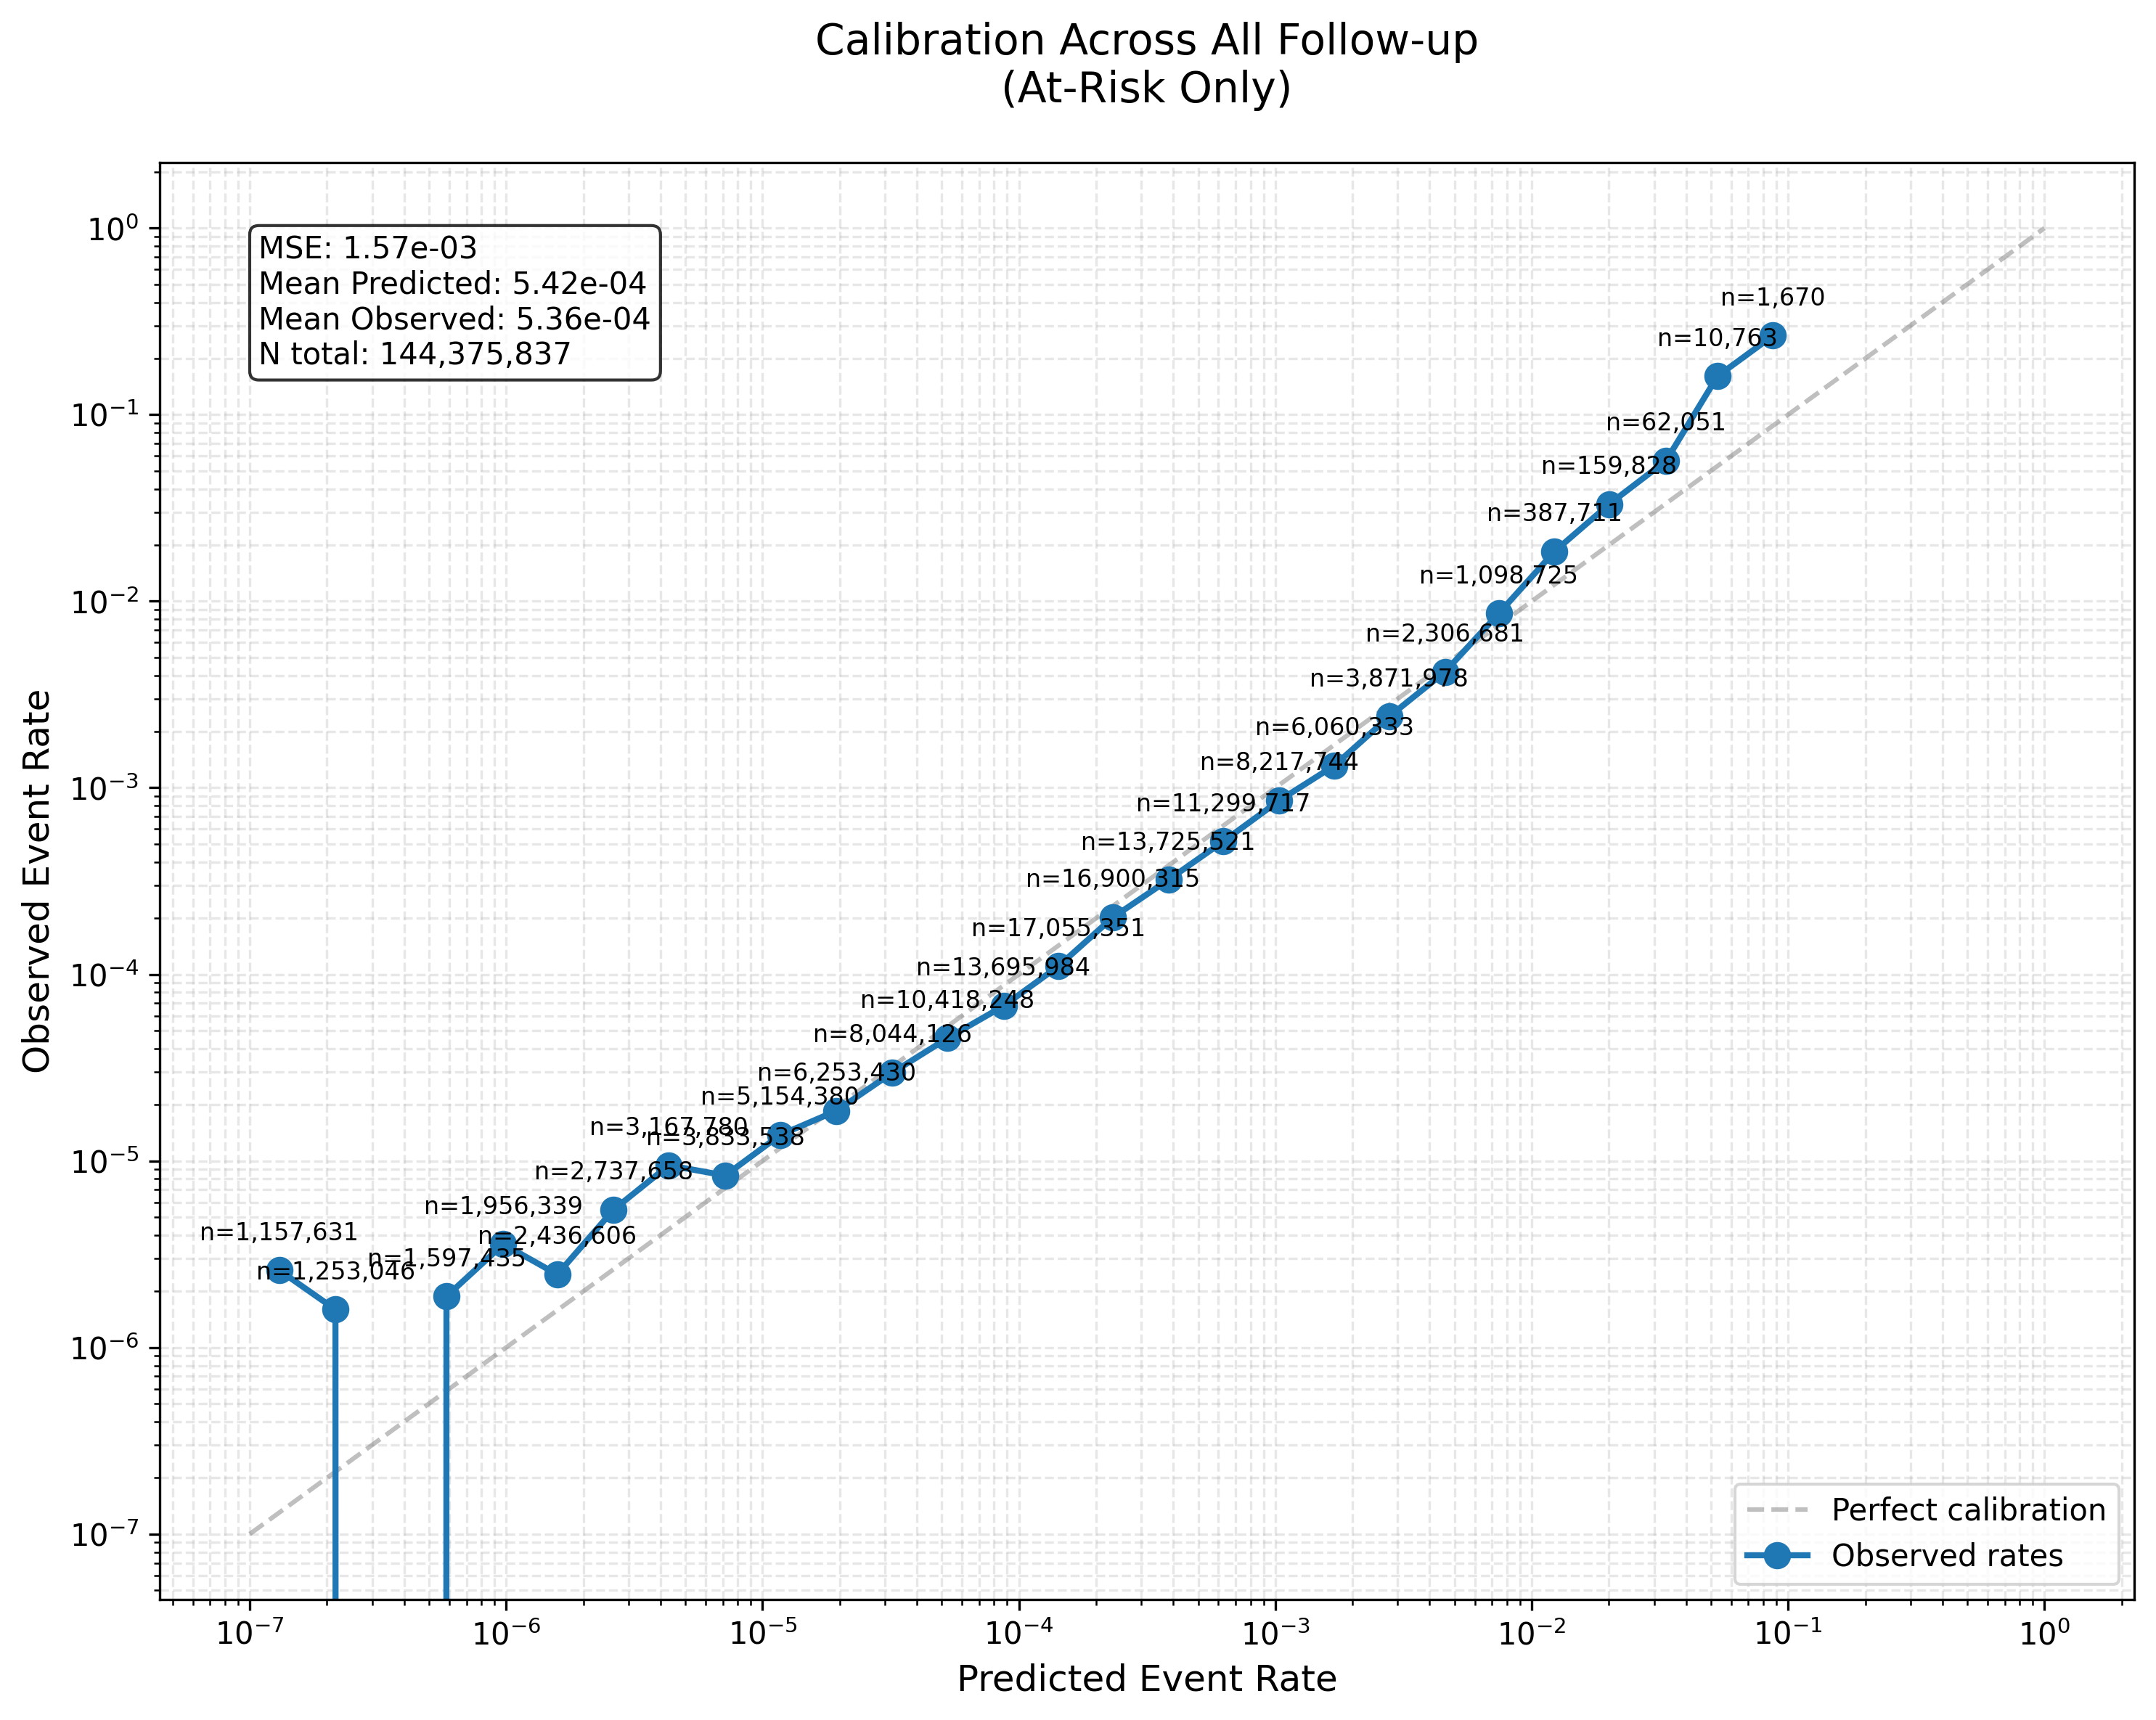

In [13]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load data
cov_df = pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv")[:10000]

# Load Y from checkpoint
checkpoint = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt", weights_only=False)
Y = checkpoint['Y'] 
del checkpoint

# Load corrected E matrix for proper at-risk filtering
E_corrected = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_matrix_corrected.pt", weights_only=False)
# Subset to match the batch size (first 10000 patients)
E_corrected = E_corrected[:10000]

print(f"✓ Loaded Y: {Y.shape}")
print(f"✓ Loaded E_corrected: {E_corrected.shape}")
print(f"✓ Loaded cov_df: {len(cov_df)} patients")

# Model checkpoint path - use the jointly estimated model trained with corrected E
# This matches the model from run_aladyn_batch_vector_e_censor.py
checkpoint_path = "/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt"

# Create calibration plots with corrected E matrix
create_proper_calibration_plots(
    checkpoint_path=checkpoint_path,
    cov_df=cov_df,
    Y=Y,
    E_corrected=E_corrected,  # Now using corrected E for proper at-risk filtering
    n_bins=30, 
    use_log_scale=True, 
    min_bin_count=1000, 
    save_path="/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/reviewer_responses/notebooks/R3/calibration_plots.pdf"
)

✓ Loaded pre-computed pi: torch.Size([50000, 348, 52])
✓ Loaded Y: torch.Size([50000, 348, 52])
✓ Loaded E_corrected: torch.Size([50000, 348])
✓ Loaded cov_df: 50000 patients

Dataset dimensions: 50000 patients × 348 diseases × 52 timepoints

Creating at-risk mask...
  Processing patient 0/50000...
✓ At-risk mask created

  Processing timepoint 0/52...
  Processing timepoint 10/52...
  Processing timepoint 20/52...
  Processing timepoint 30/52...
  Processing timepoint 40/52...
  Processing timepoint 50/52...

✓ Collected 738,708,915 predictions/observations
  Mean predicted: 5.51e-04
  Mean observed: 5.45e-04

Creating calibration plot...

✓ Saved calibration plot to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/reviewer_responses/notebooks/R3/calibration_plots_full_400k.pdf


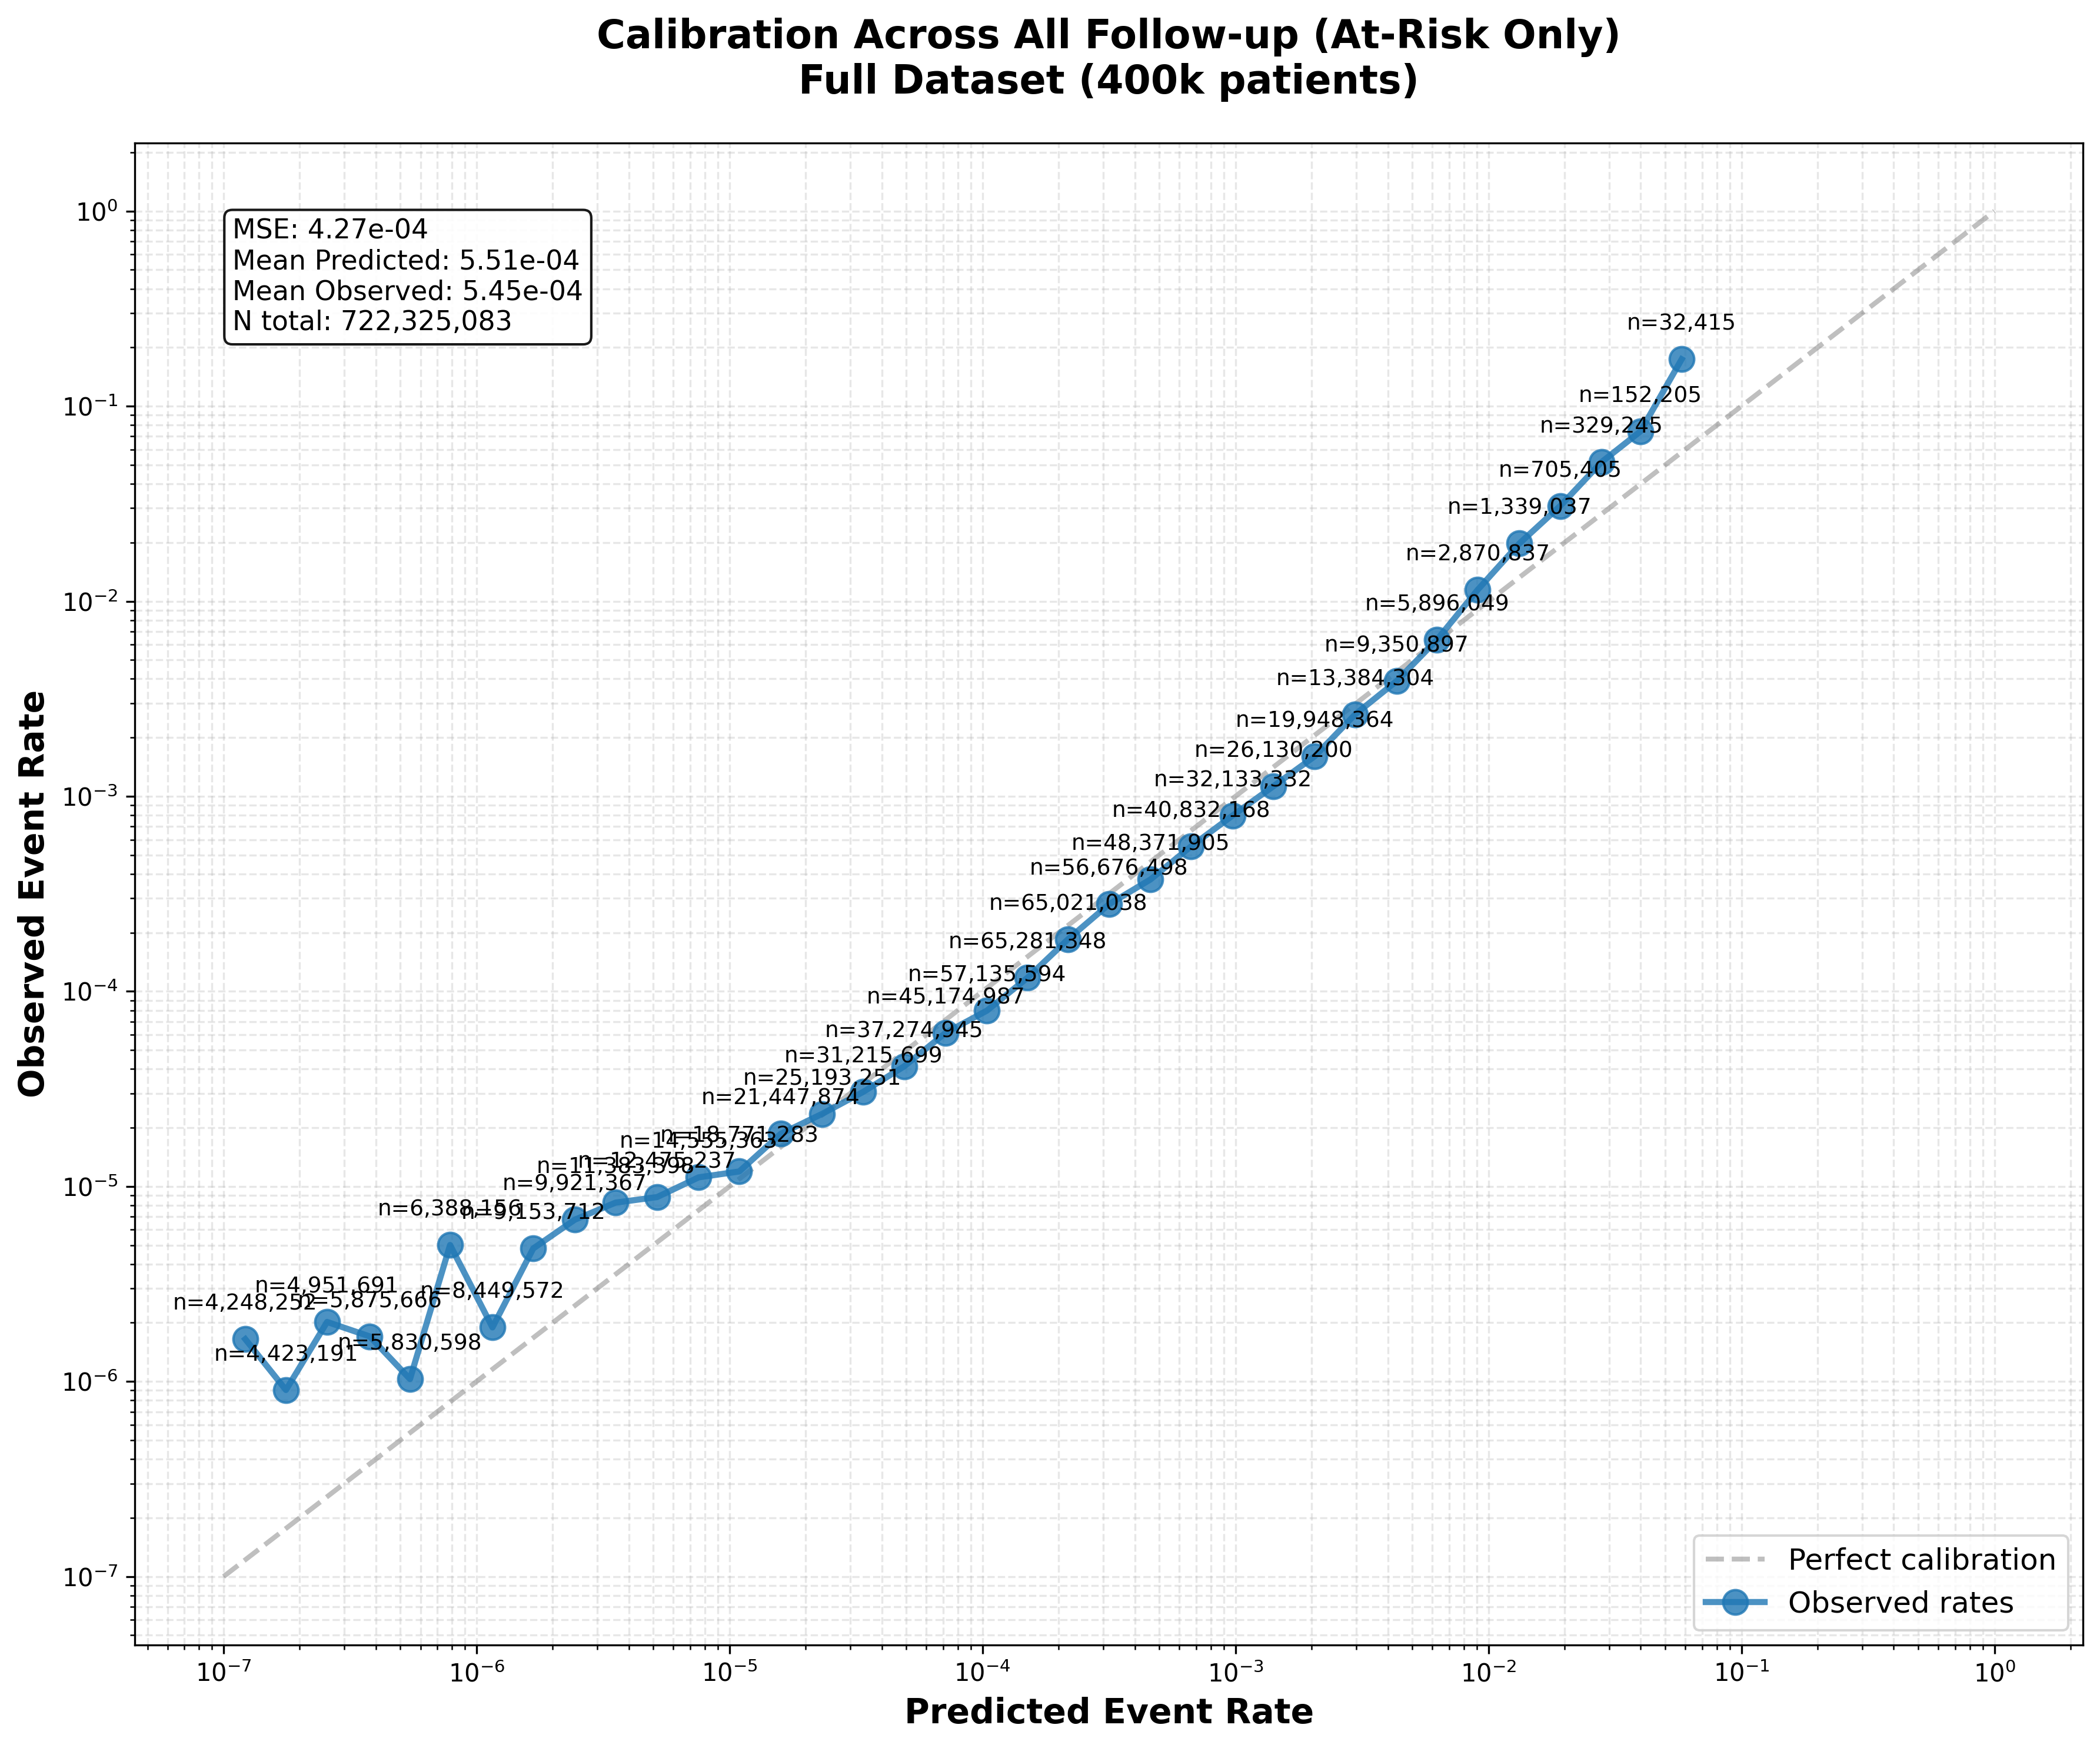

In [1]:
# ============================================================================
# Full Dataset Calibration: 400k patients using pre-computed pi
# ============================================================================

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load pre-computed pi (full 400k dataset)
pi_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/pi_fullmode_400k.pt", 
                     map_location='cpu', weights_only=False)[:50000]
print(f"✓ Loaded pre-computed pi: {pi_full.shape}")

# Load Y (full dataset)
Y_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt", 
                    map_location='cpu', weights_only=False)[:50000]
print(f"✓ Loaded Y: {Y_full.shape}")

# Load corrected E matrix (full dataset)
E_corrected_full = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_matrix_corrected.pt", 
                              map_location='cpu', weights_only=False)[:50000]
print(f"✓ Loaded E_corrected: {E_corrected_full.shape}")

# Load covariates (full dataset)
cov_df_full = pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/baselinagefamh_withpcs.csv")[:50000]
print(f"✓ Loaded cov_df: {len(cov_df_full)} patients")

# Convert to numpy
pi_np = pi_full.detach().numpy()
Y_np = Y_full.detach().numpy()
if torch.is_tensor(E_corrected_full):
    E_corrected_np = E_corrected_full.detach().numpy()
else:
    E_corrected_np = E_corrected_full

N, D, T = Y_np.shape
print(f"\nDataset dimensions: {N} patients × {D} diseases × {T} timepoints")

# Create at_risk mask using corrected E matrix
print("\nCreating at-risk mask...")
at_risk = np.zeros((N, D, T), dtype=bool)
for n in range(N):
    if n % 50000 == 0:
        print(f"  Processing patient {n}/{N}...")
    for d in range(D):
        # Patient is at risk at timepoint t if event/censor time >= t
        at_risk[n, d, :] = (E_corrected_np[n, d] >= np.arange(T))

print("✓ At-risk mask created")

# Collect all predictions and observations (at-risk only)
print("\nCollecting predictions and observations...")
all_pred = []
all_obs = []

for t in range(T):
    if t % 10 == 0:
        print(f"  Processing timepoint {t}/{T}...")
    mask_t = at_risk[:,:,t]
    if mask_t.sum() > 0:
        all_pred.extend(pi_np[:,:,t][mask_t])
        all_obs.extend(Y_np[:,:,t][mask_t])

all_pred = np.array(all_pred)
all_obs = np.array(all_obs)

print(f"\n✓ Collected {len(all_pred):,} predictions/observations")
print(f"  Mean predicted: {all_pred.mean():.2e}")
print(f"  Mean observed: {all_obs.mean():.2e}")

# Create calibration plot
print("\nCreating calibration plot...")
fig, ax = plt.subplots(figsize=(12, 10), dpi=300)

# Create bins in log space
n_bins = 40
min_bin_count = 10000  # Higher threshold for full dataset
use_log_scale = True

if use_log_scale:
    bin_edges = np.logspace(np.log10(max(1e-7, min(all_pred))), 
                          np.log10(max(all_pred)), 
                          n_bins + 1)
else:
    bin_edges = np.linspace(min(all_pred), max(all_pred), n_bins + 1)

# Calculate statistics for each bin
bin_means = []
obs_means = []
counts = []

for i in range(n_bins):
    mask = (all_pred >= bin_edges[i]) & (all_pred < bin_edges[i + 1])
    if np.sum(mask) >= min_bin_count:
        bin_means.append(np.mean(all_pred[mask]))
        obs_means.append(np.mean(all_obs[mask]))
        counts.append(np.sum(mask))

# Plot
if use_log_scale:
    ax.plot([1e-7, 1], [1e-7, 1], '--', color='gray', alpha=0.5, label='Perfect calibration', linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
else:
    ax.plot([0, max(all_pred)], [0, max(all_pred)], '--', color='gray', alpha=0.5, label='Perfect calibration', linewidth=2)

ax.plot(bin_means, obs_means, 'o-', color='#1f77b4', 
        markersize=10, linewidth=2.5, label='Observed rates', alpha=0.8)

# Add counts as annotations
for i, (x, y, c) in enumerate(zip(bin_means, obs_means, counts)):
    ax.annotate(f'n={c:,}', (x, y), xytext=(0, 12), 
               textcoords='offset points', ha='center', fontsize=9)

# Add summary statistics
mse = np.mean((np.array(bin_means) - np.array(obs_means))**2)
mean_pred = np.mean(all_pred)
mean_obs = np.mean(all_obs)

stats_text = f'MSE: {mse:.2e}\n'
stats_text += f'Mean Predicted: {mean_pred:.2e}\n'
stats_text += f'Mean Observed: {mean_obs:.2e}\n'
stats_text += f'N total: {sum(counts):,}'

ax.text(0.05, 0.95, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=11)

ax.grid(True, which='both', linestyle='--', alpha=0.3)
ax.set_xlabel('Predicted Event Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Observed Event Rate', fontsize=14, fontweight='bold')
ax.set_title('Calibration Across All Follow-up (At-Risk Only)\nFull Dataset (400k patients)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()

# Save plot
save_path = "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/reviewer_responses/notebooks/R3/calibration_plots_full_400k.pdf"
plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved calibration plot to: {save_path}")

plt.show()
